# Imports

In [1]:
import numpy as np
import nltk.corpus
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import lightgbm as lgb
import pickle
import joblib

# Reading the database

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
data.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
# No. of positive tweets
data[data['label'] == 0].count()

id       29720
label    29720
tweet    29720
dtype: int64

In [7]:
# No of negative tweets
data[data['label'] == 1].count()

id       2242
label    2242
tweet    2242
dtype: int64

# Preprocessing the data

In [8]:
data.dropna(inplace=True)

##### Removing the user tags

In [9]:
def clean_tags(tweet):
    tags = re.findall("@[\w]*", tweet)
#     print(tags)
    for i in tags:
        tweet = str.replace(tweet, i, "")
    return tweet

In [10]:
data['cleaned_tweets'] = data['tweet'].apply(clean_tags)
data.head()

,id,label,tweet,cleaned_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


##### Removing the punctuations

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
def clean_punctuations(tweet):
    punctuations = '[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
    for i in tweet:
        if i in punctuations:
            re.sub(i, "", tweet)
    return tweet
# string.punctuation

In [13]:
# print(type(string.punctuation))
data['cleaned_tweets'] = data['cleaned_tweets'].str.replace("[^A-Za-z#]", " ")
data['cleaned_tweets'].head(-5)
# data['cleaned_tweets'].iloc[31957]

C:\Users\niles\AppData\Local\Temp\ipykernel_9512\1869601397.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cleaned_tweets'] = data['cleaned_tweets'].str.replace("[^A-Za-z#]", " ")


0          when a father is dysfunctional and is so sel...
1          thanks for #lyft credit i can t use cause th...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide  society now    #motivation
                               ...                        
31952                             you went too far with   
31953    good morning #instagram #shower #water #berlin...
31954    #holiday   bull up  you will dominate your bul...
31955    less than   weeks                           #i...
31956    off fishing tomorrow  carnt wait first time in...
Name: cleaned_tweets, Length: 31957, dtype: object

##### Removing words less than a given size

In [14]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(lambda x : ["".join(word) for word in x.split() if len(word) >= 1])

In [15]:
data['cleaned_tweets']

0        [when, a, father, is, dysfunctional, and, is, ...
1        [thanks, for, #lyft, credit, i, can, t, use, c...
2                                  [bihday, your, majesty]
3        [#model, i, love, u, take, with, u, all, the, ...
4                  [factsguide, society, now, #motivation]
                               ...                        
31957                              [ate, isz, that, youuu]
31958    [to, see, nina, turner, on, the, airwaves, try...
31959    [listening, to, sad, songs, on, a, monday, mor...
31960    [#sikh, #temple, vandalised, in, in, #calgary,...
31961                       [thank, you, for, you, follow]
Name: cleaned_tweets, Length: 31962, dtype: object

In [16]:
def joinWords(tweet):
    ans = ""
    for word in tweet:
        ans = " ".join(tweet)
    return ans

In [17]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(joinWords)

In [18]:
data['cleaned_tweets']

0        when a father is dysfunctional and is so selfi...
1        thanks for #lyft credit i can t use cause they...
2                                      bihday your majesty
3           #model i love u take with u all the time in ur
4                       factsguide society now #motivation
                               ...                        
31957                                   ate isz that youuu
31958    to see nina turner on the airwaves trying to w...
31959    listening to sad songs on a monday morning otw...
31960    #sikh #temple vandalised in in #calgary #wso c...
31961                             thank you for you follow
Name: cleaned_tweets, Length: 31962, dtype: object

###### Lemmatization

In [19]:
from nltk.stem import WordNetLemmatizer

In [20]:
lemmer = WordNetLemmatizer()

In [21]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(lambda x : [lemmer.lemmatize(word) for word in x.split()])
data['cleaned_tweets'] = data['cleaned_tweets'].apply(joinWords)

In [22]:
data['cleaned_tweets'].head(-5)

0        when a father is dysfunctional and is so selfi...
1        thanks for #lyft credit i can t use cause they...
2                                      bihday your majesty
3           #model i love u take with u all the time in ur
4                       factsguide society now #motivation
                               ...                        
31952                                you went too far with
31953    good morning #instagram #shower #water #berlin...
31954    #holiday bull up you will dominate your bull a...
31955    le than week #ibiza#bringiton#mallorca#holiday...
31956    off fishing tomorrow carnt wait first time in ...
Name: cleaned_tweets, Length: 31957, dtype: object

##### Removing Hashtags

In [23]:
def removeHashtags(tweet):
    tags = re.findall("#", tweet)
#     print(tags)
    for i in tags:
        tweet = str.replace(tweet, i, "")
    return tweet

In [24]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(removeHashtags)
data['cleaned_tweets'].head(-5)
# count = 0
# for i in data['cleaned_tweets'].iloc[31953].split():
#     count += 1
# print(count)

0        when a father is dysfunctional and is so selfi...
1        thanks for lyft credit i can t use cause they ...
2                                      bihday your majesty
3            model i love u take with u all the time in ur
4                        factsguide society now motivation
                               ...                        
31952                                you went too far with
31953    good morning instagram shower water berlin ber...
31954    holiday bull up you will dominate your bull an...
31955    le than week ibizabringitonmallorcaholidayssummer
31956    off fishing tomorrow carnt wait first time in ...
Name: cleaned_tweets, Length: 31957, dtype: object

# Exploratory Data Analysis

##### Calculating Length of each tweet

In [25]:
data['length'] = data['cleaned_tweets'].apply(lambda x : len(x))
data.head(-5)

,id,label,tweet,cleaned_tweets,length
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,89
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...,102
2,3,0,bihday your majesty,bihday your majesty,19
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur,45
4,5,0,factsguide: society now #motivation,factsguide society now motivation,33
...,...,...,...,...,...
31952,31953,0,@user you went too far with @user,you went too far with,21
31953,31954,0,good morning #instagram #shower #water #berlin...,good morning instagram shower water berlin ber...,87
31954,31955,0,#holiday bull up: you will dominate your bul...,holiday bull up you will dominate your bull an...,102
31955,31956,0,less than 2 weeks ð ðð¼ð¹ððµ @us...,le than week ibizabringitonmallorcaholidayssummer,49


##### Checking to see if length dictates the sentiment of tweet

<Axes: xlabel='label', ylabel='length'>

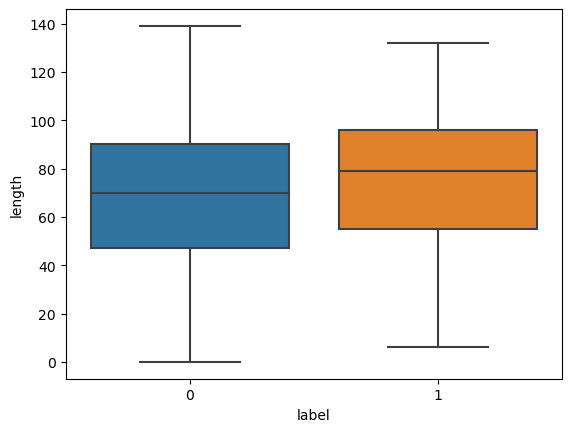

In [26]:
sns.boxplot(data = data, x = 'label', y = 'length')

##### Count of positive and negative tweets

<Axes: xlabel='label', ylabel='count'>

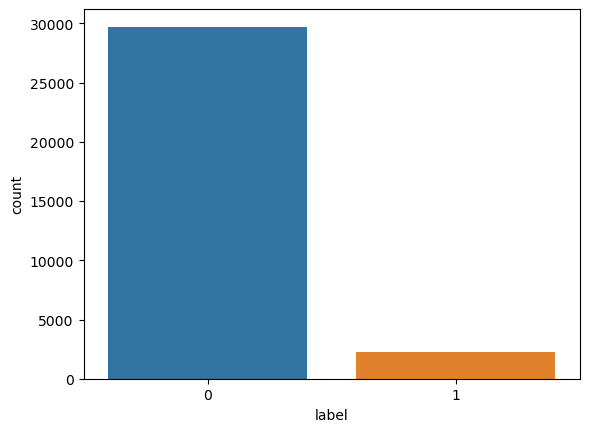

In [27]:
sns.countplot(data = data, x = 'label')

# Creating and training the model

##### Creating a bag of words

In [28]:
# def joinWords(tweet):
#     ans = ""
#     for word in tweet:
#         ans = " ".join(tweet)
#     return ans

In [29]:
allWords = ""
for tweet in data['cleaned_tweets']:
    allWords = allWords + tweet + " "

allWords = allWords.rstrip()
allWords

'when a father is dysfunctional and is so selfish he drag his kid into his dysfunction run thanks for lyft credit i can t use cause they don t offer wheelchair van in pdx disapointed getthanked bihday your majesty model i love u take with u all the time in ur factsguide society now motivation huge fan fare and big talking before they leave chaos and pay dispute when they get there allshowandnogo camping tomorrow danny the next school year is the year for exam can t think about that school exams hate imagine actorslife revolutionschool girl we won love the land allin cavs champions cleveland clevelandcavaliers welcome here i m it s so gr ireland consumer price index mom climbed from previous to in may blog silver gold forex we are so selfish orlando standwithorlando pulseshooting orlandoshooting biggerproblems selfish heabreaking values love  i get to see my daddy today  day gettingfed cnn call michigan middle school build the wall chant tcot no comment in australia opkillingbay seashep

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
count_vect = CountVectorizer(max_df=0.95, min_df= 0.05, stop_words = 'english')

In [32]:
count_vect = count_vect.fit_transform(data['cleaned_tweets'])
# count_vect = count_vect.fit_transform(df['cleaned'])

In [33]:
count_vect = count_vect.astype(np.float64)

##### Splitting the data

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [35]:
print(count_vect)

  (3, 2)	1.0
  (8, 2)	1.0
  (11, 2)	1.0
  (12, 0)	1.0
  (22, 0)	1.0
  (22, 1)	1.0
  (25, 2)	1.0
  (26, 2)	1.0
  (28, 0)	1.0
  (28, 1)	1.0
  (42, 0)	1.0
  (46, 2)	1.0
  (51, 2)	1.0
  (54, 2)	1.0
  (56, 2)	1.0
  (57, 0)	2.0
  (57, 1)	1.0
  (60, 1)	1.0
  (66, 0)	1.0
  (67, 1)	1.0
  (95, 0)	1.0
  (96, 2)	1.0
  (98, 0)	1.0
  (117, 2)	1.0
  (118, 2)	1.0
  :	:
  (31874, 2)	1.0
  (31876, 0)	1.0
  (31880, 1)	1.0
  (31881, 2)	1.0
  (31892, 2)	1.0
  (31896, 0)	1.0
  (31898, 0)	1.0
  (31899, 2)	1.0
  (31900, 0)	1.0
  (31902, 0)	1.0
  (31904, 2)	1.0
  (31905, 2)	1.0
  (31907, 2)	1.0
  (31916, 1)	1.0
  (31920, 2)	1.0
  (31921, 2)	1.0
  (31922, 1)	1.0
  (31922, 2)	1.0
  (31928, 2)	1.0
  (31935, 1)	1.0
  (31936, 1)	1.0
  (31937, 2)	1.0
  (31941, 2)	1.0
  (31944, 2)	1.0
  (31945, 0)	1.0


In [36]:
x = count_vect;
y = data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

##### Creating a model (LightGBM)

In [37]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.243025	valid_0's binary_logloss: 0.248283
[40]	training's binary_logloss: 0.24222	valid_0's binary_logloss: 0.247983
[60]	training's binary_logloss: 0.242172	valid_0's binary_logloss: 0.248091
[80]	training's binary_logloss: 0.242168	valid_0's binary_logloss: 0.248116
[100]	training's binary_logloss: 0.242168	valid_0's binary_logloss: 0.24812


C:\ProgramData\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

##### Creating a model (Logistic Regression)

In [38]:
model2 = LogisticRegression(random_state = 42)
model2.fit(x_train, y_train)

LogisticRegression(random_state=42)

##### Creating a model (Random Forrest Classifier)

In [39]:
# from sklearn.ensemble import RandomForestClassifier

In [40]:
# model3 = RandomForestClassifier(random_state = 42, verbose = 2, n_estimators=10)

In [41]:
# model3.fit(x_train, y_train)

##### Creating a model (Decision Tree)

In [42]:
# from sklearn.tree import DecisionTreeClassifier

In [43]:
# model4 = DecisionTreeClassifier(random_state = 42)

In [44]:
# model4.fit(x_train, y_train)

# Making Predictions

##### Predictions from LightGBM classifier

In [45]:
# pred = model.predict(x_test)

In [46]:
from sklearn.metrics import accuracy_score

In [47]:
# print(accuracy_score(pred, y_test))

##### Predictions from Logistic Regression model

In [48]:
pred2 = model2.predict(x_test)

In [49]:
print(accuracy_score(pred2, y_test))

0.9286682657211388


##### Predictions from RandomForrest classifier

In [50]:
# pred3 = model3.predict(x_test)

In [51]:
# print(accuracy_score(pred3, y_test))

##### Predictions from Decision Tree classifier

In [52]:
# pred4 = model4.predict(x_test)

In [53]:
# print(accuracy_score(pred4, y_test))

# Saving the best algorithm

In [54]:
from joblib import Parallel, delayed
joblib.dump(model2, "model.pkl")

['model.pkl']

# Testing the model

In [55]:
tweet = "#awesome Newbie!!! is a good boy."
tweet = "She's just jealous of me"

In [56]:
tweet = clean_tags(tweet)

In [57]:
tweet = clean_punctuations(tweet)
tweet

"She's just jealous of me"

In [58]:
tweet = removeHashtags(tweet)
tweet
d = []
d.append(tweet)
d

["She's just jealous of me"]

In [62]:
countv = CountVectorizer(stop_words = 'english', max_features=2)

In [63]:
# d = np.reshape(d, (-1, 1))
# d
c = countv.fit_transform(d)

In [64]:
prediction = model2.predict(c)

ValueError: X has 2 features, but LogisticRegression is expecting 3 features as input.

In [ ]:
prediction